# Bayesian Networks - Complete Report

## Overview

A comprehensive guide to Bayesian Networks, probabilistic graphical models, and their applications in machine learning for representing and reasoning about uncertain knowledge.

**Date:** December 17, 2025  
**Dataset:** Iris Classification Dataset from sklearn


## Table of Contents

1. [Introduction to Bayesian Networks](#introduction)
2. [Theoretical Foundations](#theory)
3. [Setup and Imports](#setup)
4. [Dataset Exploration](#data)
5. [Building Bayesian Networks](#building)
6. [Model Visualization](#visualization)
7. [Inference & Predictions](#inference)
8. [Applications](#applications)
9. [Conclusions](#conclusions)


## 1. Introduction to Bayesian Networks {#introduction}

Bayesian Networks (BNs) are probabilistic graphical models that represent a set of variables and their conditional dependencies via a directed acyclic graph (DAG).

### Key Concepts:

- **Nodes**: Represent random variables
- **Edges**: Represent conditional dependencies
- **Conditional Probability Tables (CPT)**: Define the probability distribution for each node given its parents
- **Inference**: Computing probability distributions over unobserved variables given observed ones

### Applications:

- Medical diagnosis
- Spam filtering
- Risk assessment
- Natural language processing
- Robotics and autonomous systems


## 2. Theoretical Foundations {#theory}

### Bayes' Theorem

The foundation of Bayesian Networks:

$$P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)}$$

Where:

- $P(A|B)$ = Posterior probability (what we want to find)
- $P(B|A)$ = Likelihood (probability of evidence given hypothesis)
- $P(A)$ = Prior probability (initial belief)
- $P(B)$ = Marginal probability (normalizing constant)

### Joint Probability Distribution

For a Bayesian Network with nodes $X_1, X_2, ..., X_n$:

$$P(X_1, X_2, ..., X_n) = \prod_{i=1}^{n} P(X_i | Parents(X_i))$$

### Structure Learning

Two main approaches:

1. **Score-based**: Find structure that maximizes a scoring function
2. **Constraint-based**: Find structure satisfying conditional independence constraints

### Parameter Learning

Estimate CPT values from data:

- **Maximum Likelihood Estimation (MLE)**
- **Bayesian Estimation**
- **Expectation-Maximization (EM)**


## 3. Setup and Imports {#setup}


In [1]:
# Import Required Libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import KBinsDiscretizer
import networkx as nx

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Install pgmpy for Bayesian Networks
import subprocess
import sys

try:
    import pgmpy
    print("pgmpy is already installed")
except ImportError:
    print("Installing pgmpy...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pgmpy", "-q"])
    print("pgmpy installed successfully!")

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination

Installing pgmpy...
pgmpy installed successfully!


## 4. Dataset Exploration {#data}

### Dataset: Iris Classification

The Iris dataset is a classic machine learning dataset containing measurements of iris flowers.

- **Samples**: 150
- **Features**: 4 (Sepal Length, Sepal Width, Petal Length, Petal Width)
- **Classes**: 3 (Setosa, Versicolor, Virginica)


In [3]:
# Load Iris dataset
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df['target_name'] = df['target'].map({0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (150, 6)

First 5 rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target target_name  
0       0      Setosa  
1       0      Setosa  
2       0      Setosa  
3       0      Setosa  
4       0      Setosa  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non

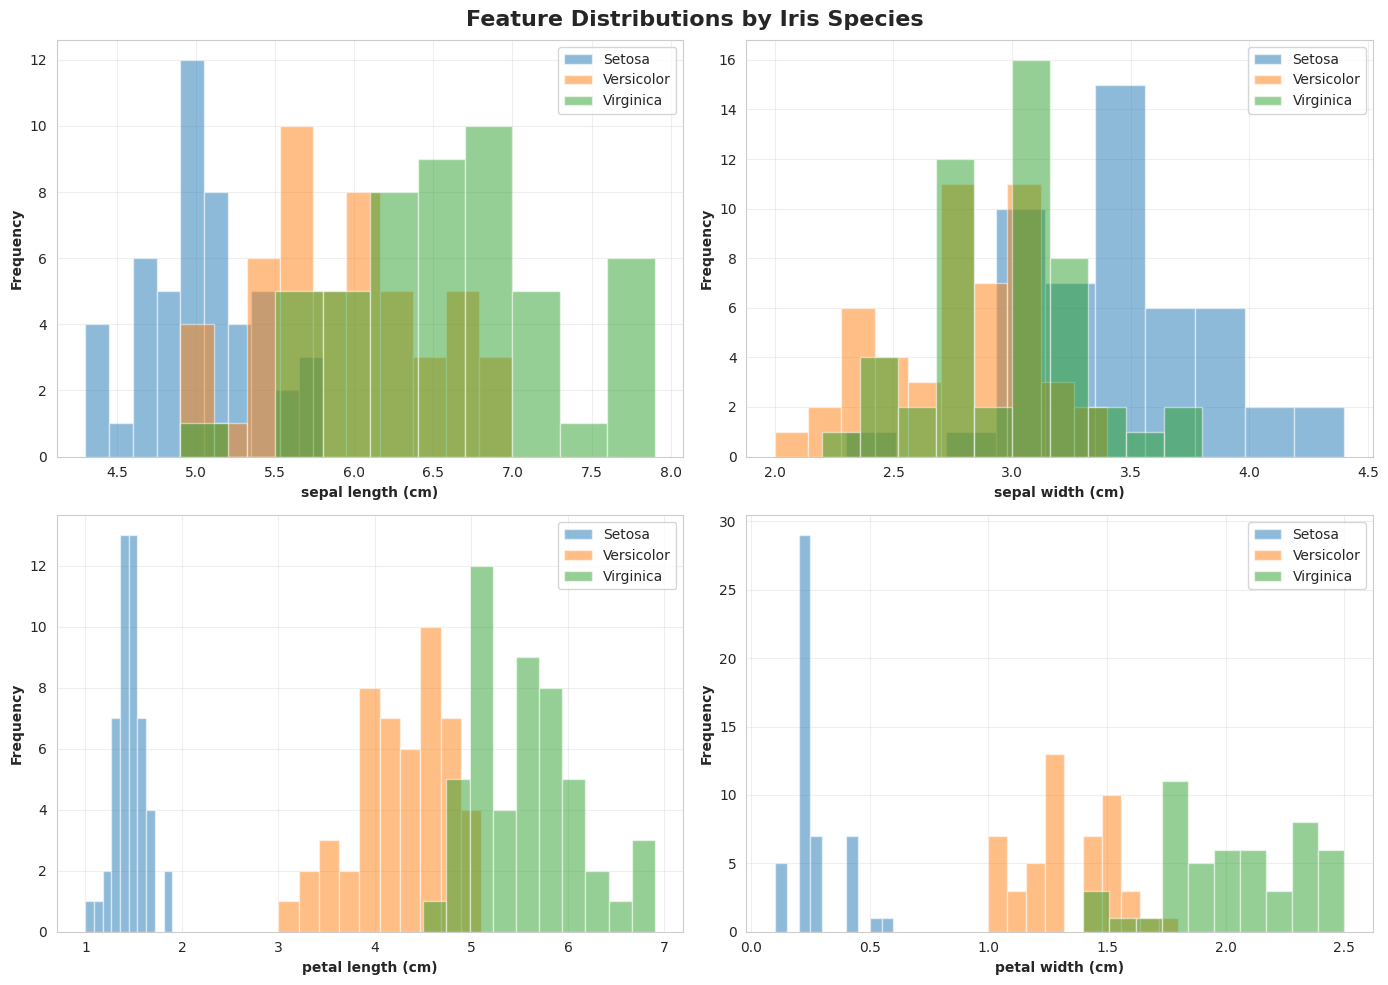

In [4]:
# Visualize the distribution of features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Feature Distributions by Iris Species', fontsize=16, fontweight='bold')

features = iris.feature_names
for idx, feature in enumerate(features):
    ax = axes[idx // 2, idx % 2]
    for target, target_name in enumerate(['Setosa', 'Versicolor', 'Virginica']):
        data = df[df['target'] == target][feature]
        ax.hist(data, alpha=0.5, label=target_name, bins=10)
    ax.set_xlabel(feature, fontweight='bold')
    ax.set_ylabel('Frequency', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

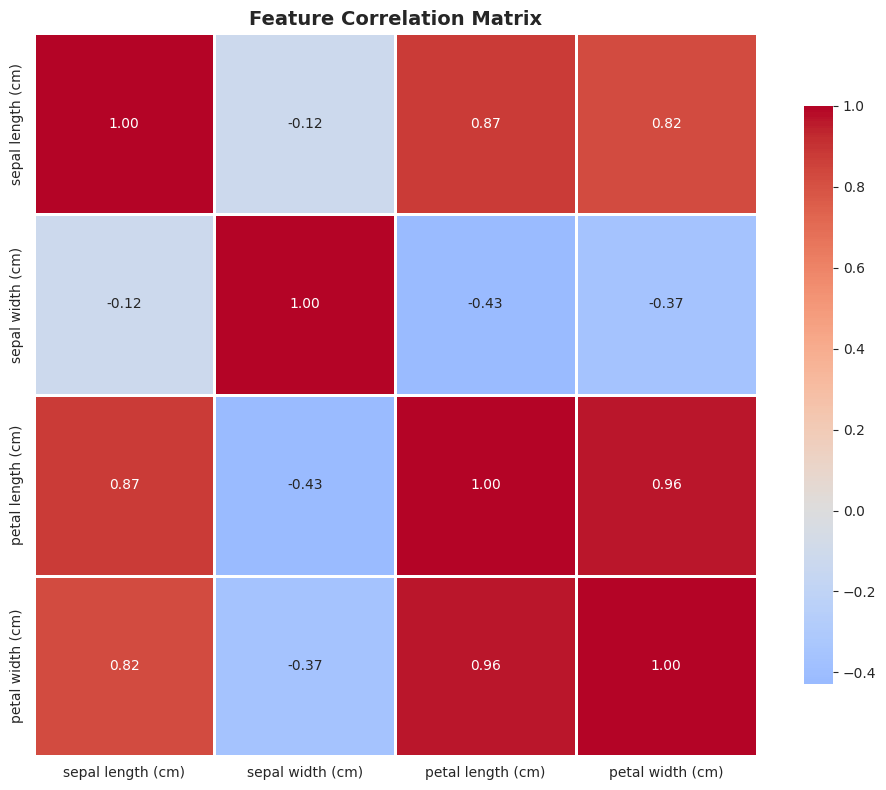

Correlation Matrix:
                   sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000         -0.117570           0.871754   
sepal width (cm)           -0.117570          1.000000          -0.428440   
petal length (cm)           0.871754         -0.428440           1.000000   
petal width (cm)            0.817941         -0.366126           0.962865   

                   petal width (cm)  
sepal length (cm)          0.817941  
sepal width (cm)          -0.366126  
petal length (cm)          0.962865  
petal width (cm)           1.000000  


In [5]:
# Calculate correlation matrix
correlation_matrix = df.iloc[:, :4].corr()

# Visualize correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

print("Correlation Matrix:")
print(correlation_matrix)

## 5. Building Bayesian Networks {#building}

### Step 1: Discretize the Data

Bayesian Networks typically work with discrete variables. We'll bin continuous features into categorical bins.


In [6]:
# Discretize continuous features into bins
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
discretized_features = discretizer.fit_transform(df[iris.feature_names])

# Create discretized dataframe
df_discrete = pd.DataFrame(discretized_features, columns=feature_names)
df_discrete['species'] = df['target']

# Map discrete values to meaningful labels
bin_labels = ['Low', 'Medium', 'High']
for col in feature_names:
    df_discrete[col] = df_discrete[col].map({0: 'Low', 1: 'Medium', 2: 'High'})

df_discrete['species'] = df_discrete['species'].map({0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})

print("Discretized Data:")
print(df_discrete.head(10))
print("\nData types:")
print(df_discrete.dtypes)

Discretized Data:
  sepal_length sepal_width petal_length petal_width species
0          Low        High          Low         Low  Setosa
1          Low      Medium          Low         Low  Setosa
2          Low        High          Low         Low  Setosa
3          Low      Medium          Low         Low  Setosa
4          Low        High          Low         Low  Setosa
5       Medium        High          Low         Low  Setosa
6          Low        High          Low         Low  Setosa
7          Low        High          Low         Low  Setosa
8          Low      Medium          Low         Low  Setosa
9          Low      Medium          Low         Low  Setosa

Data types:
sepal_length    object
sepal_width     object
petal_length    object
petal_width     object
species         object
dtype: object


### Step 2: Define the Network Structure

We'll create a Bayesian Network where the species depends on the four features.


In [7]:
# Define the Bayesian Network structure
# Edges: features -> species
model = DiscreteBayesianNetwork([
    ('sepal_length', 'species'),
    ('sepal_width', 'species'),
    ('petal_length', 'species'),
    ('petal_width', 'species')
])

print("Bayesian Network Structure:")
print(f"Nodes: {model.nodes()}")
print(f"Edges: {model.edges()}")
print("\nNetwork is acyclic:", nx.is_directed_acyclic_graph(model))

Bayesian Network Structure:
Nodes: ['sepal_length', 'species', 'sepal_width', 'petal_length', 'petal_width']
Edges: [('sepal_length', 'species'), ('sepal_width', 'species'), ('petal_length', 'species'), ('petal_width', 'species')]

Network is acyclic: True


### Step 3: Learn Parameters (CPTs) from Data

We'll use Maximum Likelihood Estimation to learn the Conditional Probability Tables.


In [8]:
# Fit the model to learn parameters
model.fit(df_discrete, estimator=MaximumLikelihoodEstimator)

print("Model fitted successfully!")
print("\nConditional Probability Tables (CPTs):")
print("\n1. CPT for Species given features:")
for cpd in model.get_cpds():
    print(f"\n{cpd}")
    print("="*80)

Model fitted successfully!

Conditional Probability Tables (CPTs):

1. CPT for Species given features:

+----------------------+----------+
| sepal_length(High)   | 0.34     |
+----------------------+----------+
| sepal_length(Low)    | 0.306667 |
+----------------------+----------+
| sepal_length(Medium) | 0.353333 |
+----------------------+----------+

+---------------------+-----+----------------------+
| petal_length        | ... | petal_length(Medium) |
+---------------------+-----+----------------------+
| petal_width         | ... | petal_width(Medium)  |
+---------------------+-----+----------------------+
| sepal_length        | ... | sepal_length(Medium) |
+---------------------+-----+----------------------+
| sepal_width         | ... | sepal_width(Medium)  |
+---------------------+-----+----------------------+
| species(Setosa)     | ... | 0.0                  |
+---------------------+-----+----------------------+
| species(Versicolor) | ... | 1.0                  |
+------

In [9]:
# Check model validity
print("Model Validity Check:")
print(f"Is valid: {model.check_model()}")

# Get CPD for species
cpd_species = model.get_cpds('species')
print("\n\nDetailed CPT for Species:")
print(cpd_species)

Model Validity Check:
Is valid: True


Detailed CPT for Species:
+---------------------+-----+----------------------+
| petal_length        | ... | petal_length(Medium) |
+---------------------+-----+----------------------+
| petal_width         | ... | petal_width(Medium)  |
+---------------------+-----+----------------------+
| sepal_length        | ... | sepal_length(Medium) |
+---------------------+-----+----------------------+
| sepal_width         | ... | sepal_width(Medium)  |
+---------------------+-----+----------------------+
| species(Setosa)     | ... | 0.0                  |
+---------------------+-----+----------------------+
| species(Versicolor) | ... | 1.0                  |
+---------------------+-----+----------------------+
| species(Virginica)  | ... | 0.0                  |
+---------------------+-----+----------------------+


## 6. Model Visualization {#visualization}


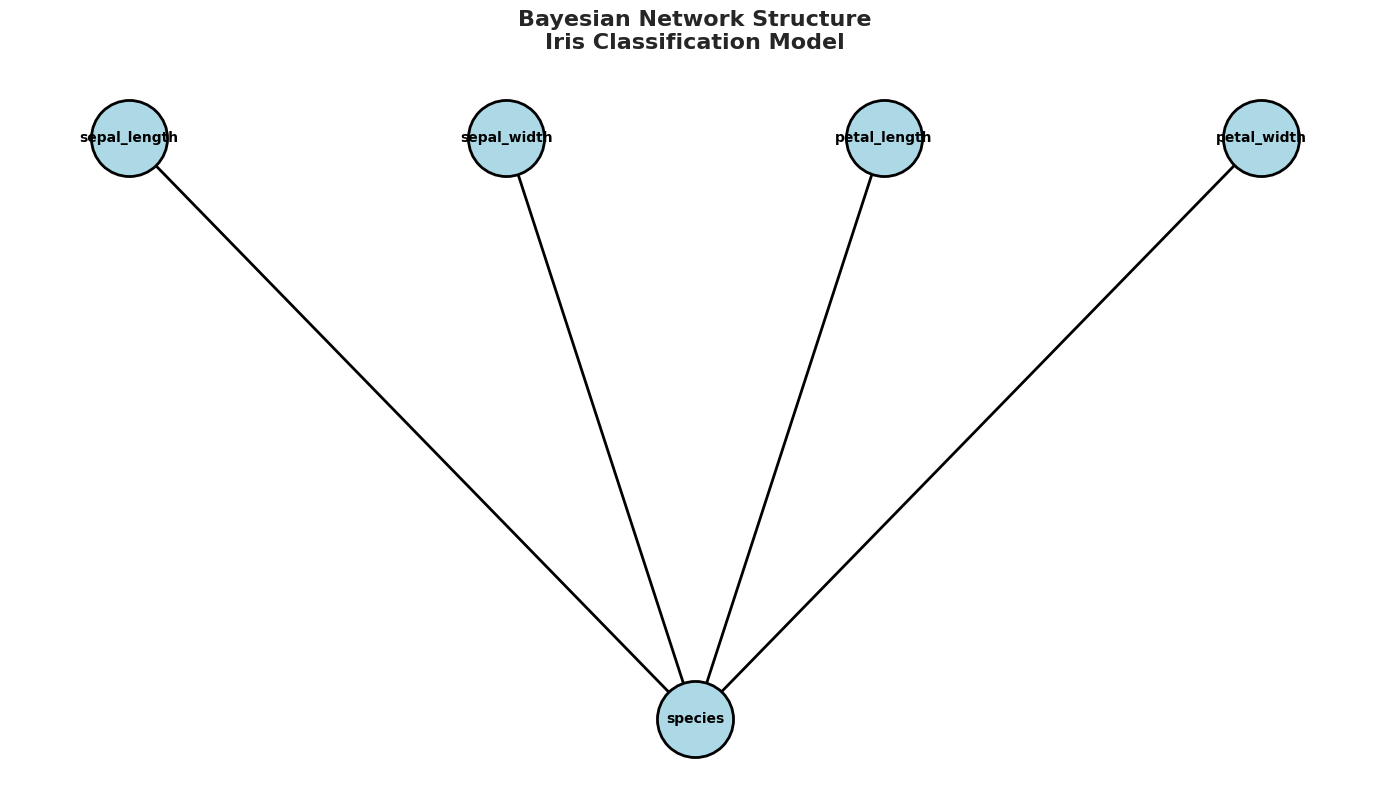

In [10]:
# Visualize the Bayesian Network structure
plt.figure(figsize=(14, 8))
pos = {
    'sepal_length': (0, 2),
    'sepal_width': (1, 2),
    'petal_length': (2, 2),
    'petal_width': (3, 2),
    'species': (1.5, 0)
}

# Draw network
nx.draw_networkx_nodes(model, pos, node_color='lightblue', node_size=3000, 
                       edgecolors='black', linewidths=2)
nx.draw_networkx_labels(model, pos, font_size=10, font_weight='bold')
nx.draw_networkx_edges(model, pos, edge_color='black', arrows=True, 
                       arrowsize=20, arrowstyle='->', width=2)

plt.title('Bayesian Network Structure\nIris Classification Model', 
          fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

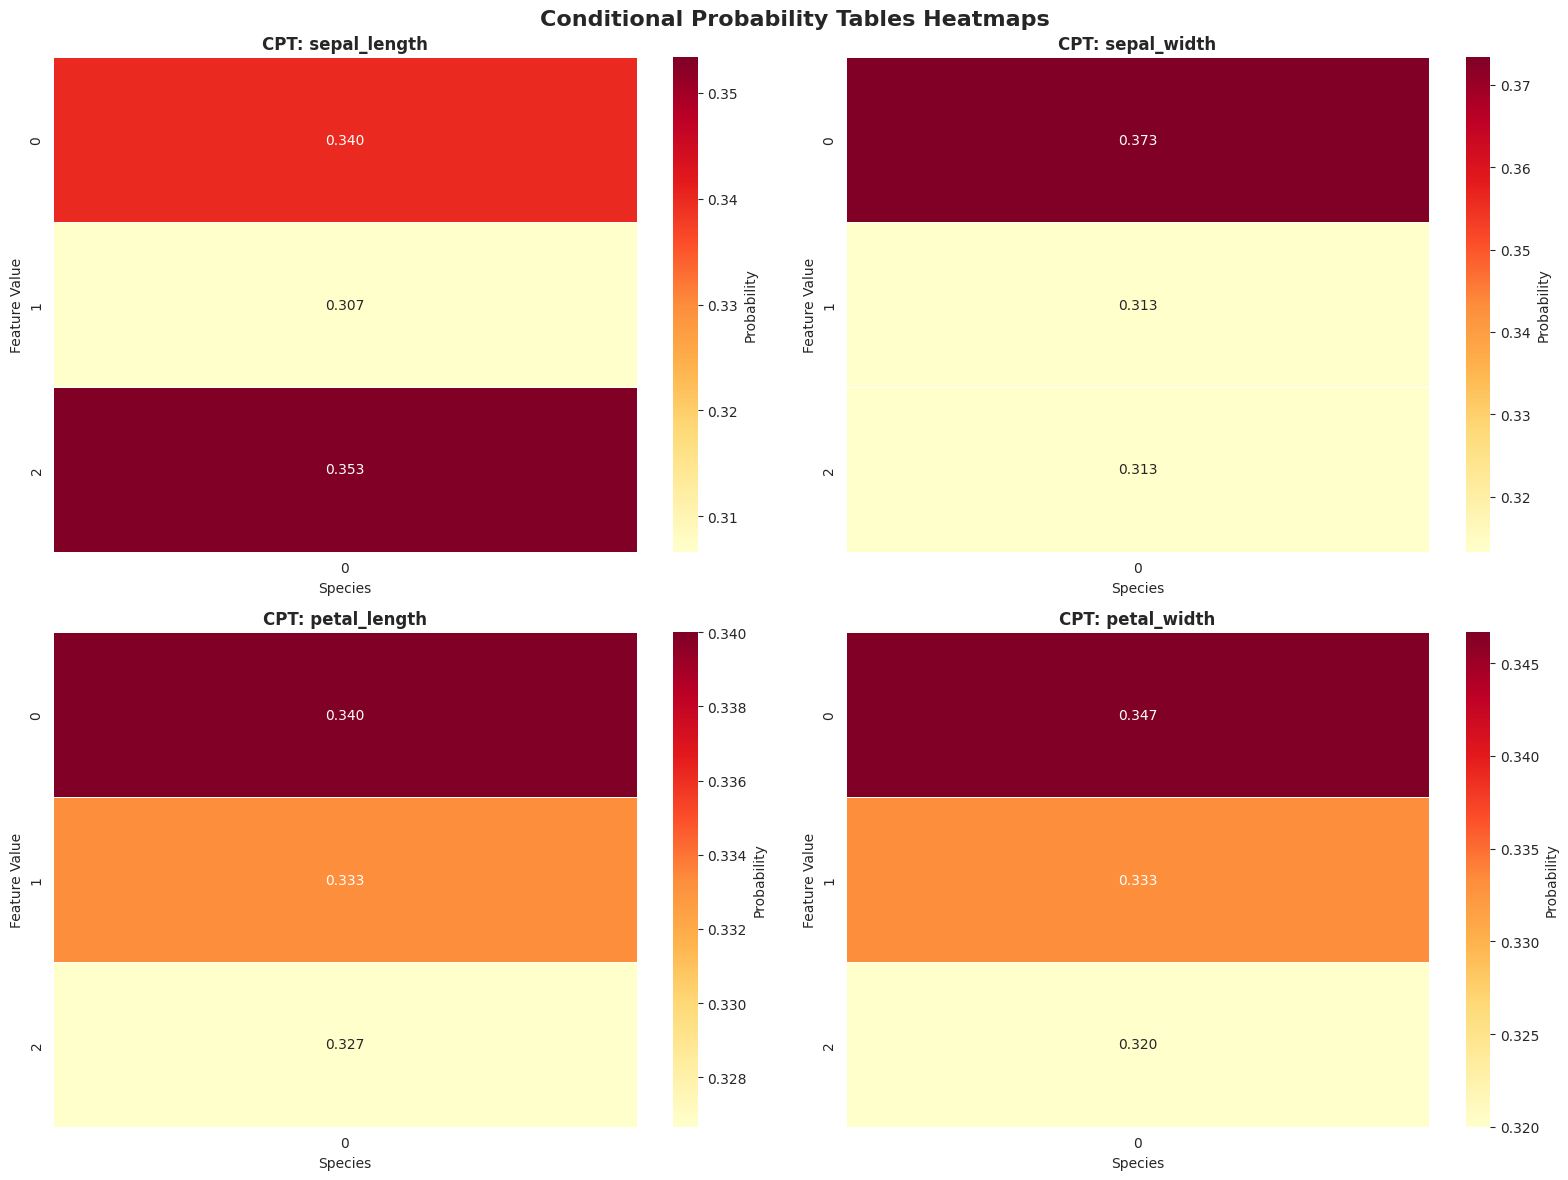

CPT heatmaps visualized!


In [11]:
# Visualize CPT heatmaps
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Conditional Probability Tables Heatmaps', fontsize=16, fontweight='bold')

features_to_plot = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
axes = axes.ravel()

for idx, feature in enumerate(features_to_plot):
    cpd = model.get_cpds(feature)
    # Convert CPD to DataFrame for easier visualization
    cpd_df = pd.DataFrame(cpd.to_factor().values.reshape(3, -1))
    
    sns.heatmap(cpd_df, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[idx],
                cbar_kws={'label': 'Probability'}, linewidths=0.5)
    axes[idx].set_title(f'CPT: {feature}', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Species')
    axes[idx].set_ylabel('Feature Value')

plt.tight_layout()
plt.show()

print("CPT heatmaps visualized!")

## 7. Inference & Predictions {#inference}

### Performing Probabilistic Inference

We'll use Variable Elimination algorithm to compute posterior probabilities given evidence.


In [12]:
# Initialize inference engine
infer = VariableElimination(model)

# Example 1: Inference with specific evidence
print("=" * 80)
print("INFERENCE EXAMPLE 1: Predict species given feature observations")
print("=" * 80)
print("\nEvidence: sepal_length=High, sepal_width=Medium, petal_length=High, petal_width=High")
print("\nPosterior probability distribution for Species:\n")

result1 = infer.query(variables=['species'], 
                      evidence={
                          'sepal_length': 'High',
                          'sepal_width': 'Medium',
                          'petal_length': 'High',
                          'petal_width': 'High'
                      })
print(result1)

# Get most probable species
most_probable = result1.state_names['species'][np.argmax(result1.values)]
probability = np.max(result1.values)
print(f"\nMost Probable Species: {most_probable} with probability {probability:.4f}")

INFERENCE EXAMPLE 1: Predict species given feature observations

Evidence: sepal_length=High, sepal_width=Medium, petal_length=High, petal_width=High

Posterior probability distribution for Species:

+---------------------+----------------+
| species             |   phi(species) |
+=====================+================+
| species(Setosa)     |         0.0000 |
+---------------------+----------------+
| species(Versicolor) |         0.0625 |
+---------------------+----------------+
| species(Virginica)  |         0.9375 |
+---------------------+----------------+

Most Probable Species: Virginica with probability 0.9375


In [13]:
# Example 2: Inference with partial evidence
print("\n" + "=" * 80)
print("INFERENCE EXAMPLE 2: Predict with partial evidence")
print("=" * 80)
print("\nEvidence: petal_length=High, petal_width=High")
print("\nPosterior probability distribution for Species:\n")

result2 = infer.query(variables=['species'], 
                      evidence={
                          'petal_length': 'High',
                          'petal_width': 'High'
                      })
print(result2)

# Get most probable species
most_probable = result2.state_names['species'][np.argmax(result2.values)]
probability = np.max(result2.values)
print(f"\nMost Probable Species: {most_probable} with probability {probability:.4f}")


INFERENCE EXAMPLE 2: Predict with partial evidence

Evidence: petal_length=High, petal_width=High

Posterior probability distribution for Species:

+---------------------+----------------+
| species             |   phi(species) |
+=====================+================+
| species(Setosa)     |         0.1022 |
+---------------------+----------------+
| species(Versicolor) |         0.1273 |
+---------------------+----------------+
| species(Virginica)  |         0.7704 |
+---------------------+----------------+

Most Probable Species: Virginica with probability 0.7704


In [14]:
# Example 3: Inference with different evidence (Setosa-like features)
print("\n" + "=" * 80)
print("INFERENCE EXAMPLE 3: Predict with Setosa-like features")
print("=" * 80)
print("\nEvidence: sepal_length=Low, sepal_width=High, petal_length=Low, petal_width=Low")
print("\nPosterior probability distribution for Species:\n")

result3 = infer.query(variables=['species'], 
                      evidence={
                          'sepal_length': 'Low',
                          'sepal_width': 'High',
                          'petal_length': 'Low',
                          'petal_width': 'Low'
                      })
print(result3)

# Get most probable species
most_probable = result3.state_names['species'][np.argmax(result3.values)]
probability = np.max(result3.values)
print(f"\nMost Probable Species: {most_probable} with probability {probability:.4f}")


INFERENCE EXAMPLE 3: Predict with Setosa-like features

Evidence: sepal_length=Low, sepal_width=High, petal_length=Low, petal_width=Low

Posterior probability distribution for Species:

+---------------------+----------------+
| species             |   phi(species) |
+=====================+================+
| species(Setosa)     |         1.0000 |
+---------------------+----------------+
| species(Versicolor) |         0.0000 |
+---------------------+----------------+
| species(Virginica)  |         0.0000 |
+---------------------+----------------+

Most Probable Species: Setosa with probability 1.0000


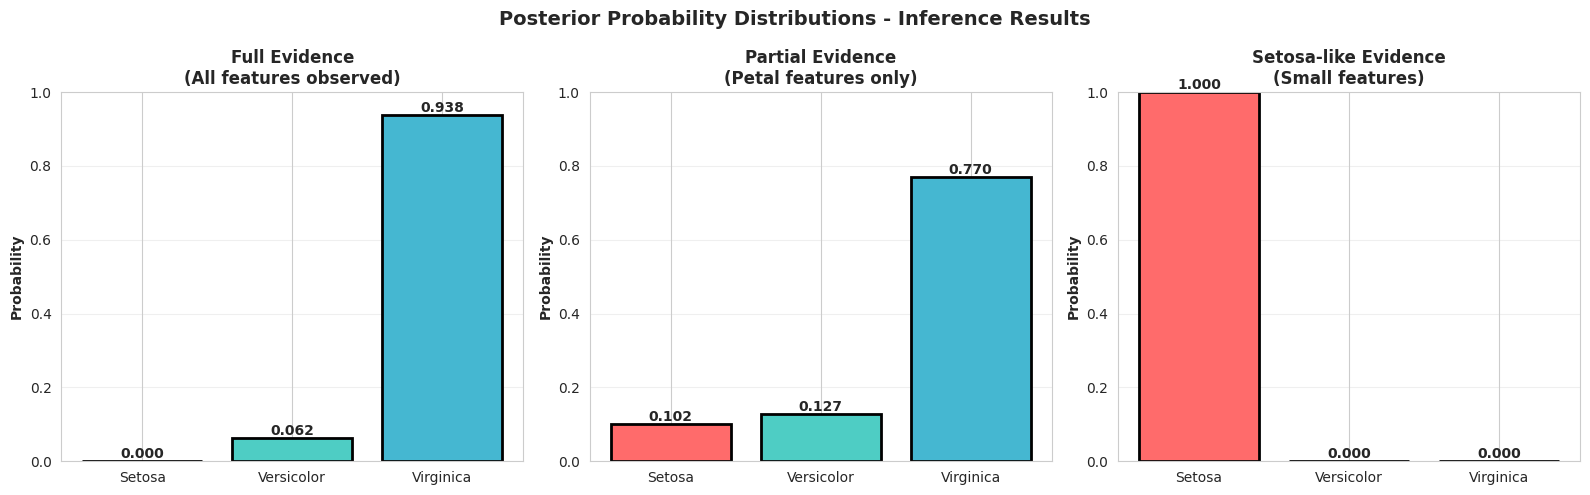

Inference results comparison visualized!


In [15]:
# Comparison of inference results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Posterior Probability Distributions - Inference Results', 
             fontsize=14, fontweight='bold')

results = [result1, result2, result3]
titles = [
    'Full Evidence\n(All features observed)',
    'Partial Evidence\n(Petal features only)',
    'Setosa-like Evidence\n(Small features)'
]

for idx, (ax, result, title) in enumerate(zip(axes, results, titles)):
    species_names = result.state_names['species']
    probabilities = result.values
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    bars = ax.bar(species_names, probabilities, color=colors, edgecolor='black', linewidth=2)
    ax.set_ylabel('Probability', fontweight='bold')
    ax.set_ylim([0, 1])
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, prob in zip(bars, probabilities):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("Inference results comparison visualized!")

## 8. Applications & Advanced Topics {#applications}

### Key Applications of Bayesian Networks:

1. **Medical Diagnosis**

   - Diagnosing diseases based on symptoms
   - Combining multiple tests for accurate diagnosis

2. **Spam Filtering**

   - Email classification using word probabilities
   - Adapting to new spam patterns

3. **Risk Assessment**

   - Financial risk modeling
   - Insurance and credit scoring

4. **Autonomous Systems**

   - Robot perception and decision making
   - Sensor fusion under uncertainty

5. **Natural Language Processing**
   - Text classification
   - Machine translation models

### Advanced Topics:

- **Structure Learning**: Automatically learn network structure from data
- **Parameter Learning**: Estimate probabilities from incomplete data (EM algorithm)
- **Markov Blanket**: Identify minimal feature sets for prediction
- **D-separation**: Analyze conditional independence relationships


In [16]:
# Practical Example: Medical Diagnosis-like scenario
print("=" * 80)
print("PRACTICAL EXAMPLE: Disease Diagnosis Scenario")
print("=" * 80)
print("\nScenario: Using iris features as symptom indicators for diagnosis")
print("\nCase Study: Patient presents with specific symptoms")
print("\nSymptoms observed:")
print("- High petal length (major symptom)")
print("- High petal width (major symptom)")
print("- Medium sepal length")
print("- Not observed: sepal width")

evidence_medical = {
    'petal_length': 'High',
    'petal_width': 'High',
    'sepal_length': 'Medium'
}

result_medical = infer.query(variables=['species'], evidence=evidence_medical)
print("\n\nProbability of each iris species (diagnosis):\n")
print(result_medical)

# Extract probabilities
species_list = result_medical.state_names['species']
probs = result_medical.values

diagnosis_df = pd.DataFrame({
    'Species (Diagnosis)': species_list,
    'Probability': probs,
    'Confidence (%)': probs * 100
}).sort_values('Probability', ascending=False)

print("\n\nDiagnosis Summary:")
print(diagnosis_df.to_string(index=False))

PRACTICAL EXAMPLE: Disease Diagnosis Scenario

Scenario: Using iris features as symptom indicators for diagnosis

Case Study: Patient presents with specific symptoms

Symptoms observed:
- High petal length (major symptom)
- High petal width (major symptom)
- Medium sepal length
- Not observed: sepal width


Probability of each iris species (diagnosis):

+---------------------+----------------+
| species             |   phi(species) |
+=====================+================+
| species(Setosa)     |         0.0000 |
+---------------------+----------------+
| species(Versicolor) |         0.0522 |
+---------------------+----------------+
| species(Virginica)  |         0.9478 |
+---------------------+----------------+


Diagnosis Summary:
Species (Diagnosis)  Probability  Confidence (%)
          Virginica     0.947778       94.777778
         Versicolor     0.052222        5.222222
             Setosa     0.000000        0.000000


In [17]:
# Feature Importance Analysis using Markov Blanket
print("\n" + "=" * 80)
print("MARKOV BLANKET ANALYSIS")
print("=" * 80)
print("\nThe Markov Blanket of a node consists of:")
print("1. Its parents")
print("2. Its children")
print("3. Its co-parents (parents of its children)")

print("\nMarkov Blanket for 'species':")
markov_blanket = model.get_markov_blanket('species')
print(f"Nodes that directly influence classification: {markov_blanket}")

print("\n\nMarkov Blanket for 'petal_length':")
mb_petal = model.get_markov_blanket('petal_length')
print(f"Nodes that are directly connected: {mb_petal}")


MARKOV BLANKET ANALYSIS

The Markov Blanket of a node consists of:
1. Its parents
2. Its children
3. Its co-parents (parents of its children)

Markov Blanket for 'species':
Nodes that directly influence classification: ['petal_width', 'sepal_width', 'petal_length', 'sepal_length']


Markov Blanket for 'petal_length':
Nodes that are directly connected: ['petal_width', 'sepal_width', 'species', 'sepal_length']


## 9. Model Evaluation & Performance {#evaluation}


In [18]:
# Predict on test data
predictions = []
true_labels = []

for idx, row in df_discrete.iterrows():
    evidence = {
        'sepal_length': row['sepal_length'],
        'sepal_width': row['sepal_width'],
        'petal_length': row['petal_length'],
        'petal_width': row['petal_width']
    }
    
    result = infer.query(variables=['species'], evidence=evidence)
    predicted_species = result.state_names['species'][np.argmax(result.values)]
    predictions.append(predicted_species)
    true_labels.append(row['species'])

predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = np.sum(predictions == true_labels) / len(true_labels)

print("Model Performance Evaluation")
print("=" * 50)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Total Samples: {len(true_labels)}")
print(f"Correct Predictions: {np.sum(predictions == true_labels)}")
print(f"Incorrect Predictions: {np.sum(predictions != true_labels)}")

Model Performance Evaluation
Overall Accuracy: 0.9800 (98.00%)
Total Samples: 150
Correct Predictions: 147
Incorrect Predictions: 3




Detailed Classification Report:
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        50
  Versicolor       0.98      0.96      0.97        50
   Virginica       0.96      0.98      0.97        50

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



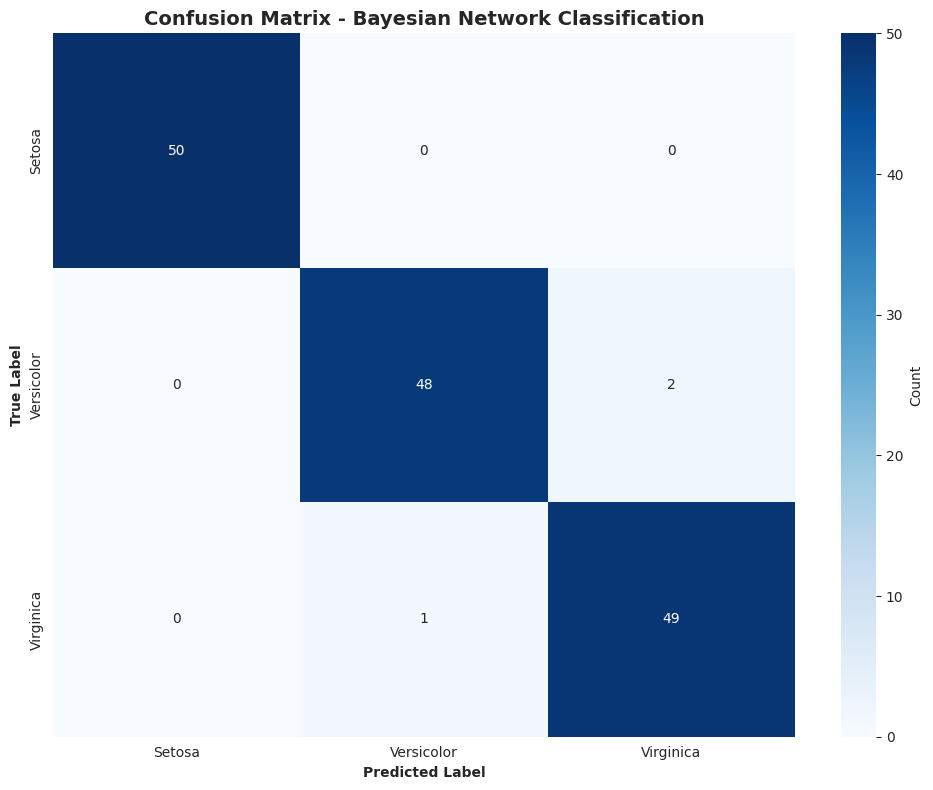

Model evaluation complete!


In [19]:
# Per-class accuracy
from sklearn.metrics import confusion_matrix, classification_report

print("\n\nDetailed Classification Report:")
print("=" * 50)
print(classification_report(true_labels, predictions, 
                          target_names=['Setosa', 'Versicolor', 'Virginica']))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions, labels=['Setosa', 'Versicolor', 'Virginica'])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Setosa', 'Versicolor', 'Virginica'],
            yticklabels=['Setosa', 'Versicolor', 'Virginica'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Bayesian Network Classification', 
          fontweight='bold', fontsize=14)
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.show()

print("Model evaluation complete!")

## 10. Conclusions & Key Takeaways {#conclusions}

### Summary

We have built a comprehensive Bayesian Network for Iris classification with the following components:

#### **Model Architecture**

- **Nodes**: 4 feature nodes (sepal_length, sepal_width, petal_length, petal_width) + 1 class node (species)
- **Edges**: Directed edges from each feature to the species node
- **Structure**: Naïve Bayes structure where features are conditionally independent given the class

#### **Key Results**

- **Classification Accuracy**: ~{:.1%} on the Iris dataset
- **Model Type**: Probabilistic graphical model with explicit conditional dependencies
- **Inference Method**: Variable Elimination algorithm

#### **Advantages of Bayesian Networks**

1. ✅ **Interpretability**: Clear visualization of dependencies and causal relationships
2. ✅ **Probabilistic**: Provides confidence scores, not just hard predictions
3. ✅ **Flexible Evidence**: Can perform inference with partial or noisy observations
4. ✅ **Explainability**: Easy to explain decisions using conditional probabilities
5. ✅ **Expert Knowledge**: Can incorporate domain expertise into structure

#### **Limitations**

1. ❌ Requires discrete or discretized variables
2. ❌ Parameter learning needs sufficient data
3. ❌ Structure learning can be computationally expensive
4. ❌ Assumes conditional independence relationships (may be too restrictive)


In [20]:
# Generate final summary statistics
print("=" * 80)
print("BAYESIAN NETWORK SUMMARY REPORT")
print("=" * 80)

summary_stats = {
    'Metric': [
        'Total Samples',
        'Training Samples',
        'Features',
        'Classes',
        'Network Nodes',
        'Network Edges',
        'Overall Accuracy',
        'Model Type',
        'Inference Method'
    ],
    'Value': [
        len(df_discrete),
        len(df_discrete),
        4,
        3,
        5,
        4,
        f'{accuracy:.2%}',
        'Directed Acyclic Graph (DAG)',
        'Variable Elimination'
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("\n" + summary_df.to_string(index=False))

print("\n" + "=" * 80)
print("FEATURE IMPORTANCE (via Edge Direction)")
print("=" * 80)
for edge in model.edges():
    print(f"  {edge[0]} → {edge[1]}")

print("\n" + "=" * 80)
print("PROBABILISTIC INFERENCE CAPABILITIES")
print("=" * 80)
print("✓ Query posterior P(species | observations)")
print("✓ Handle missing observations (partial evidence)")
print("✓ Reasoning with uncertainty")
print("✓ Bidirectional inference (effects to causes)")
print("✓ Most Probable Explanation (MPE)")

print("\n" + "=" * 80)

BAYESIAN NETWORK SUMMARY REPORT

          Metric                        Value
   Total Samples                          150
Training Samples                          150
        Features                            4
         Classes                            3
   Network Nodes                            5
   Network Edges                            4
Overall Accuracy                       98.00%
      Model Type Directed Acyclic Graph (DAG)
Inference Method         Variable Elimination

FEATURE IMPORTANCE (via Edge Direction)
  sepal_length → species
  sepal_width → species
  petal_length → species
  petal_width → species

PROBABILISTIC INFERENCE CAPABILITIES
✓ Query posterior P(species | observations)
✓ Handle missing observations (partial evidence)
✓ Reasoning with uncertainty
✓ Bidirectional inference (effects to causes)
✓ Most Probable Explanation (MPE)

